In [84]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
from priordist import PriorDistributionCell

In [85]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [86]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/scripts/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

250 ms time bins

In [87]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Get durations of each navigation phase
nav_intervals = trial_timestamps[1:,:].T
nav_durations = nav_intervals[:,1] - nav_intervals[:,0]
nav_durations = nav_durations.astype(np.int8)

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,0]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

In [88]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
nav_durations = nav_durations[trial_filt]
trial_intervals = trial_intervals[trial_filt]

In [89]:
# Bin entire session into 250 ms time bins, aligned to the start of each cue phase for each trial
session_intervals = list()
delta = 0.25  # Size of time bin (in seconds)
for idx, intvl in enumerate(trial_intervals):
    trial_start, trial_end = intvl
    for time in np.arange(trial_start, trial_end - delta, delta):
        session_intervals.append(np.array([time, time + delta]))
session_intervals = np.array(session_intervals)

# Divide cue phases into 250 ms time bins
new_cue_intervals = np.empty((cue_intervals.shape[0], cue_intervals.shape[1], 4))
for num, intvl in enumerate(cue_intervals):
    st_time, ed_time = intvl
    for prd in range(int(1/delta)):
        new_cue_intervals[num,0,prd] = st_time + delta * prd
        new_cue_intervals[num,1,prd] = st_time + delta * (prd + 1)
full_cue_intervals = cue_intervals
cue_intervals = new_cue_intervals

In [90]:
# Get number of cells in dataset
num_cells = len(cell_labels)

# Slot spikes into cue phase intervals for each trial
spikecounts_per_trial = np.empty((cue_intervals.shape[0], num_cells, cue_intervals.shape[2]))

for prd in range(cue_intervals.shape[2]):
    spikecounts_per_trial[:,:,prd] = spike_counts_per_observation(cue_intervals[:,:,prd], spike_times)

# Slot spikes into session time intervals
spikecounts_across_session = spike_counts_per_observation(session_intervals, spike_times)

In [91]:
# Sanity check
spikecounts_cue_phase = np.sum(spikecounts_per_trial, axis=2)

# Get distribution of spike timings within each 1s time bin
spiketimes_per_trial_full = spike_times_per_observation(full_cue_intervals, spike_times)

# Get distribution of spike timings within each 250 ms time bin
spiketimes_per_trial = list()
for prd in range(cue_intervals.shape[2]):
    spiketimes_per_trial.append(spike_times_per_observation(cue_intervals[:,:,prd], spike_times))

In [92]:
# Bin spike counts within each cell for entire sesion, and get firing rate thresholds used for binning
binned_spikes_across_session = np.empty_like(spikecounts_across_session)
binning_stats = list()
for col in range(spikecounts_across_session.shape[1]):
    binned_spikes_across_session[:,col] = bin_firing_rates_4(spikecounts_across_session[:,col])
    binning_stats.append(get_binning_stats_4(spikecounts_across_session[:,col]))

# Bin spike counts within each cell for cue phases
binned_spikes_per_trial = np.empty_like(spikecounts_per_trial)
for prd in range(spikecounts_per_trial.shape[2]):
    for col in range(spikecounts_per_trial.shape[1]):
        binned_spikes_per_trial[:,col,prd] = bin_firing_rates_4(spikecounts_per_trial[:,col,prd], stats=binning_stats[col])

In [93]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

In [94]:
# Group cue phase spikes according to goal
responses_per_goal = list()
for prd in range(binned_spikes_per_trial.shape[2]):
    responses_per_goal.append(group_by_goal(binned_spikes_per_trial[:,:,prd], trial_markers))

# Get distribution of population responses across entire session
response_distribution_session = list()
for responses in responses_per_goal:
    response_distribution_session.append(PriorDistributionCell(binned_spikes_across_session, responses))

In [95]:
# Some important constants
num_goals = 6
num_cats = 4
num_prds = 4

In [96]:
# Shannon entropy across goals
goal_entropy = 0
for goal in range(num_goals):
    P_s = response_distribution_session[0].P_s(goal)
    goal_entropy -= P_s * np.log2(P_s)

print(goal_entropy)

2.573664397104504


In [97]:
np.log2(6)

2.584962500721156

In [98]:
# Unconditioned entropy of responses across entire session
session_entropy = np.zeros(num_cells)
for cell in range(num_cells):
    for cat in range(num_cats):
        P_r = response_distribution_session[0].P_r(cell, cat)
        if P_r != 0:
            session_entropy[cell] -= P_r * np.log2(P_r)

print(session_entropy)

[0.         1.39749526 0.         0.         0.         0.99341797
 1.548415   0.98286032 1.97789231 0.         1.93343674 0.
 0.        ]


In [99]:
# Conditioned entropy of responses per goal
goal_response_entropy = np.zeros((num_goals, num_cells, num_prds))
for prd in range(num_prds):
    for goal in range(num_goals):
        for cell in range(num_cells):
            for cat in range(num_cats):
                P_r_s = response_distribution_session[prd].P_r_s(cell, cat, goal)
                if P_r_s != 0:
                    goal_response_entropy[goal, cell, prd] -= P_r_s * np.log2(P_r_s)

In [100]:
# Information gain per stimulus (relative to entire session responses)
information_gain = np.zeros((num_goals, num_cells, num_prds))
for prd in range(num_prds):
    for goal in range(num_goals):
        for cell in range(num_cells):
            for cat in range(num_cats):
                P_r_s = response_distribution_session[prd].P_r_s(cell, cat, goal)
                P_r = response_distribution_session[prd].P_r(cell, cat)
                if P_r_s != 0:
                    information_gain[goal, cell, prd] += P_r_s * np.log2(P_r_s / P_r)

In [101]:
# Net information gain acrosss entire stimuli set
net_information_gain = np.zeros((num_cells, num_prds))
for prd in range(num_prds):
    for cell in range(num_cells):
        for goal in range(num_goals):
            I_s_R = information_gain[goal, cell, prd]
            P_s = response_distribution_session[prd].P_s(goal)
            net_information_gain[cell, prd] += P_s * I_s_R

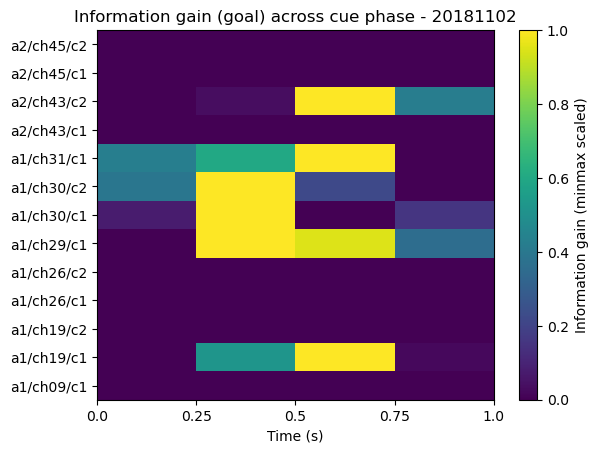

In [153]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

def scale_values(arr: np.array) -> np.array:
    res = np.empty_like(arr)
    tot = np.sum(arr)
    if tot == 0:
        tot = 1
    for i, val in enumerate(arr):
        res[i] = val / tot
    return res

net_information_gain_scaled = np.empty_like(net_information_gain)
for idx, row in enumerate(net_information_gain):
    net_information_gain_scaled[idx,:] = minmax_scale(row)

plt.figure()
plt.pcolormesh(net_information_gain_scaled)
plt.colorbar(label='Information gain (minmax scaled)')
plt.title(f'Information gain (goal) across cue phase - {day_dir}')
plt.xlabel('Time (s)')
plt.xticks(np.arange(int(1/delta)+1), [delta * i for i in range(0, int(1/delta)+1)])
plt.yticks(np.arange(0.5, num_cells+0.5), cell_labels)
plt.show()

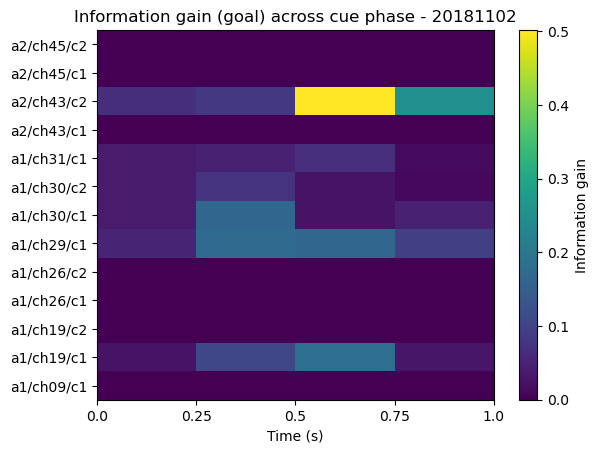

In [154]:
plt.figure()
plt.pcolormesh(net_information_gain)
plt.colorbar(label='Information gain')
plt.title(f'Information gain (goal) across cue phase - {day_dir}')
plt.xlabel('Time (s)')
plt.xticks(np.arange(int(1/delta)+1), [delta * i for i in range(0, int(1/delta)+1)])
plt.yticks(np.arange(0.5, num_cells+0.5), cell_labels)
plt.show()

In [210]:
# Pick cell name/cell num for visualization
cell_name = 'a1/ch19/c1'  # Specify cell name
cell_num = cell_labels.index(cell_name)
# cell_num = 1  # Specify cell num (0-indexed)
# cell_name = cell_labels[cell_num]

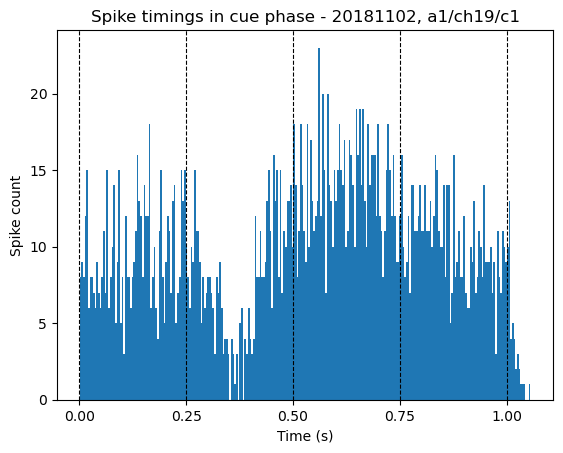

In [211]:
# Visualize spike timing distribution for cue phase for one cell
# Pool all responses from all trials for one cell
cell_spike_times = [spiketimes_per_trial_full[i][cell_num] for i in range(len(spiketimes_per_trial_full))]
cell_spike_times_arr = np.array([], dtype=np.float64)
for arr in cell_spike_times:
    cell_spike_times_arr = np.append(cell_spike_times_arr, arr)
cell_spike_times_arr = np.sort(cell_spike_times_arr)
# cell_spike_times_arr = cell_spike_times_arr[np.where(cell_spike_times_arr <= 1)]

# Plot distribution of spike timings as histogram
plt.figure()
plt.hist(cell_spike_times_arr, bins=int(cell_spike_times_arr.shape[0]/10))
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8)
plt.axvline(x=0.25, color='k', linestyle='--', linewidth=0.8)
plt.axvline(x=0.5, color='k', linestyle='--', linewidth=0.8)
plt.axvline(x=0.75, color='k', linestyle='--', linewidth=0.8)
plt.axvline(x=1, color='k', linestyle='--', linewidth=0.8)
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.title(f'Spike timings in cue phase - {day_dir}, {cell_name}')
plt.xlabel('Time (s)')
plt.ylabel('Spike count')
plt.show()

Text(0, 0.5, 'Spike counts')

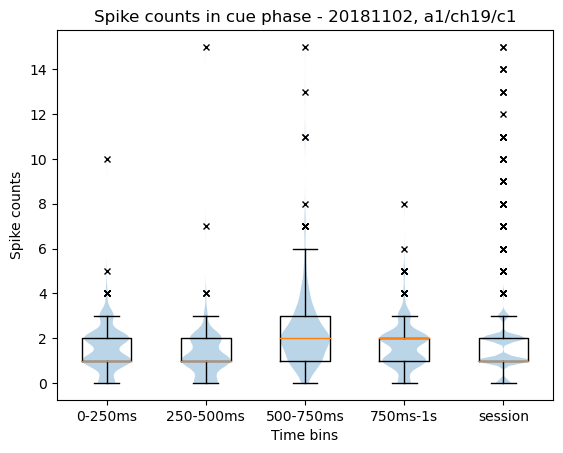

In [212]:
# Violin plots of spike counts in each cue phase time bin, as well as throughout session
cell_spikecounts_cue = spikecounts_per_trial[:,cell_num,:].T
cell_spikecounts_session = spikecounts_across_session[:,cell_num]
violin_data = list()
for row in cell_spikecounts_cue:
    violin_data.append(row)
violin_data.append(cell_spikecounts_session)

plt.figure()
plt.title(f'Spike counts in cue phase - {day_dir}, {cell_name}')
plt.boxplot(violin_data, flierprops={'marker': 'x', 'markersize': 5})
plt.violinplot(violin_data, showextrema=False)
plt.xticks(np.arange(1, int(1/delta)+2), labels=['0-250ms', '250-500ms', '500-750ms', '750ms-1s', 'session'])
plt.xlabel('Time bins')
plt.ylabel('Spike counts')

Text(0, 0.5, 'Spike counts')

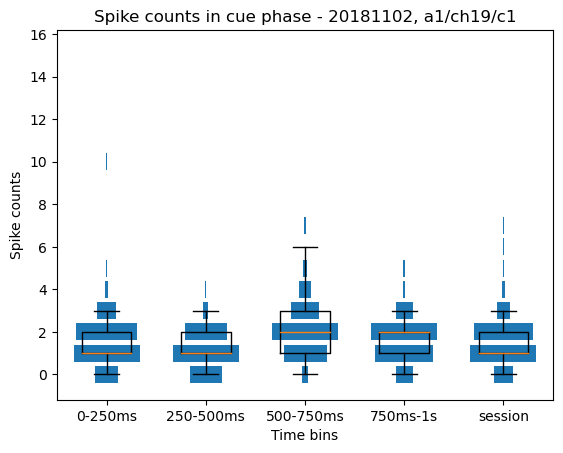

In [213]:
# Violin plots of spike counts in each cue phase time bin, as well as throughout session
cell_spikecounts_cue = spikecounts_per_trial[:,cell_num,:].T
cell_spikecounts_session = spikecounts_across_session[:,cell_num]
violin_data = list()
for row in cell_spikecounts_cue:
    violin_data.append(row)
violin_data.append(cell_spikecounts_session)

hist_data = [np.histogram(data, bins=int(max(data)-min(data)+1))[0] for data in violin_data]
hist_ranges = [np.arange(int(min(data)), int(max(data))+1) for data in violin_data]

plt.figure()
plt.title(f'Spike counts in cue phase - {day_dir}, {cell_name}')
plt.boxplot(violin_data, showfliers=False)
plt.xticks(np.arange(1, int(1/delta)+2), labels=['0-250ms', '250-500ms', '500-750ms', '750ms-1s', 'session'])
for i in range(len(hist_data)):
    plt.barh(hist_ranges[i], hist_data[i]/(3*max(hist_data[i])), left=i+1, color='C0')
    plt.barh(hist_ranges[i], -hist_data[i]/(3*max(hist_data[i])), left=i+1, color='C0')
plt.xlabel('Time bins')
plt.ylabel('Spike counts')

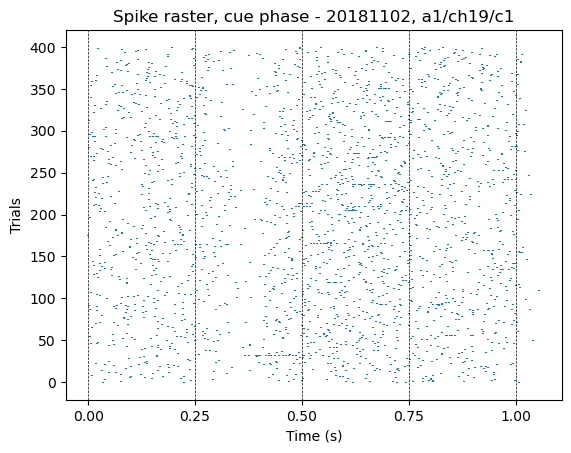

In [214]:
# Visualize spike timings of cell as a raster plot
plt.figure()
plt.eventplot(cell_spike_times)
plt.title(f'Spike raster, cue phase - {day_dir}, {cell_name}')
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0.25, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0.5, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0.75, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='k', linestyle='--', linewidth=0.5)
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel('Time (s)')
plt.ylabel('Trials')
plt.show()

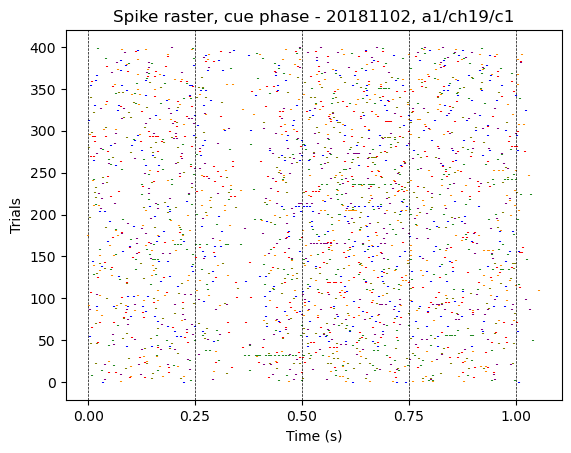

In [215]:
# Visualize spike timings of cell as a raster plot
# Split trials into each plotting colour
colour_list = ['blue','darkorange','forestgreen','purple','olive','red']
plt.figure()
for i, trial in enumerate(cell_spike_times):
    plt.eventplot(trial, colors=colour_list[i % len(colour_list)], lineoffsets=i)
plt.title(f'Spike raster, cue phase - {day_dir}, {cell_name}')
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0.25, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0.5, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0.75, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='k', linestyle='--', linewidth=0.5)
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel('Time (s)')
plt.ylabel('Trials')
plt.show()